# 2-Fold Target Encoding — **Item** (Out-of-Fold) based on *Total Spent*

Performs **2-Fold Target Encoding** for the **Item** column using **Total Spent** as the target.

> **Pipeline position:** Run this after Customer ID encoding.  
> **Input:** `encoded_customer_id_dataset.csv`  
> **Outputs:**  
> - Encoded dataset: `encoded_item_dataset.csv` (adds `Item Target Encoded`)  
> - Final mapping (fit on full data): `item_target_encoding_mapping_2fold.csv` (for applying to external/test data)


In [ ]:
# === Setup: libraries & file names ===
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# Input/Output files
CSV_IN = Path("../../output/1_handle_missing_data/final_cleaned_dataset.csv")
CSV_OUT = Path("../../output/2_handle_encoding_data/encoded_item_dataset.csv")

# Columns
ITEM        = "Item"
TARGET_COL  = "Total Spent"
ENCODED_COL = "Item Target Encoded"

# 2-Fold parameters
nSplits = 2          # fixed to 2-fold
randomState = 42     # random seed for reproducibility
shuffle = True       # shuffle before split

In [3]:
# Load data
df = pd.read_csv(CSV_IN)

In [4]:
# Ensure target is numeric
# .to_numeric with errors="coerce" will convert non-numeric to NaN
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# row/col count & null summary
rowCount, colCount = df.shape
nullSummary = df[[ITEM, TARGET_COL]].isnull().sum()

# print basic info
print(f"Rows: {rowCount}, Cols: {colCount}")
print("\nNulls in key columns:")
print(nullSummary)

Rows: 11971, Cols: 12

Nulls in key columns:
Item           0
Total Spent    0
dtype: int64


## Why 2-Fold target encoding for *Item*?
- **Item** is a **predictive category**: 
  + Some items are associated with higher/lower `Total Spent`.
  + Machine Learning model will rely on it heavily. We must be stricter about avoiding leakage.
- 2-Fold OOF encoding avoids self-leakage while remaining **simple and fast**.

### Method (2-Fold OOF)
Split data into two folds: **A** and **B**.  
- Encode **A** using per-Item means computed **only from B**.  
- Encode **B** using per-Item means computed **only from A**.  
- Items unseen in the opposite fold → use **global mean**.
Finally, fit per-Item means on the **full dataset** and save the mapping for test-time usage.


In [5]:
# 2-Fold target encoding
# Initialize KFold with 2 splits, shuffling, and a random state for reproducibility
kf = KFold(n_splits=nSplits, shuffle=shuffle, random_state=randomState)

# Calculate global mean of the target
globalMean = df[TARGET_COL].mean()
# Prepare a Series to hold the encoded values with the same index as df
encoded = pd.Series(index=df.index, dtype=float)

# Perform 2-Fold target encoding
# fold variables: train_idx, val_idx
# start=1 to make fold count human-friendly (1, 2, ...)
# kf.split separates df into training and validation fold
for fold, (train_idx, val_idx) in enumerate(kf.split(df), start=1):
    # For 2-fold: 'train_idx' is the opposite fold used to compute means, 'val_idx' is the fold we encode
    train = df.iloc[train_idx] # opposite fold
    val   = df.iloc[val_idx]  # current fold to encode
    means = train.groupby(ITEM)[TARGET_COL].mean() # Calculate mean target per Item in training fold
    encodedValues = val[ITEM].map(means).fillna(globalMean) # Map means to validation fold, fill NaN with global mean
    encoded.iloc[val_idx] = encodedValues.values # Assign encoded values to the correct positions in the encoded Series
    # Diagnostics
    print(f"Fold {fold}: opposite(train)={len(train_idx)} encode(val)={len(val_idx)} | unique Items in opposite={means.index.nunique()}")

# Attach encoded feature
df[ENCODED_COL] = encoded

# Diagnostics
print("\nEncoded summary:")
print(df[ENCODED_COL].describe())

Fold 1: opposite(train)=5985 encode(val)=5986 | unique Items in opposite=200
Fold 2: opposite(train)=5986 encode(val)=5985 | unique Items in opposite=200

Encoded summary:
count    11971.000000
mean       129.839852
std         59.113998
min         22.500000
25%         79.613636
50%        132.650943
75%        176.433333
max        335.750000
Name: Item Target Encoded, dtype: float64


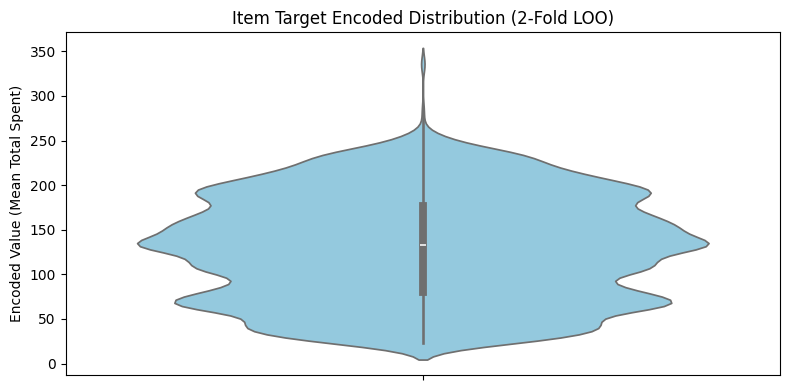

In [6]:


plt.figure(figsize=(8, 4))
sns.violinplot(
    data=df[[ENCODED_COL]],
    y=ENCODED_COL,
    inner="box",
    color="skyblue"
)
plt.title("Item Target Encoded Distribution (2-Fold LOO)")
plt.ylabel("Encoded Value (Mean Total Spent)")
plt.tight_layout()
plt.show()


- Y-axis shows the target-encoded value: it’s the mean Total Spent associated with each item after the 2-fold leave-one-out logic.
- Blue violin shape is the distribution of those encoded values. Wherever the violin is wide, many items share that spend level; narrow sections mean only a few items sit there.
- Gray box-and-whisker inside marks the quartiles and median. The median (thin horizontal line) lands around 120, so a typical item drives about $120 in spend. The box captures the middle 50% of items.
- Upper tail stretches toward ~330, telling us a handful of items are linked to very high spend averages.
- Lower tail tapers toward zero, meaning some items correspond to very small spend.

In [7]:
# Save encoded dataset
df.to_csv(CSV_OUT, index=False)
print(f"Saved encoded dataset: {CSV_OUT.resolve()}")
print(f"New column: {ENCODED_COL}  |  Global mean fallback = {df[TARGET_COL].mean():.6f}")

Saved encoded dataset: D:\CP610\encoded_output_data\2_item\encoded_item_dataset.csv
New column: Item Target Encoded  |  Global mean fallback = 129.652577
